In [168]:
import os
import csv
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import scipy.signal as signal
import noisereduce as nr
import seaborn as sns
import pywt
import pywt.data
# Ruta de la carpeta con los modelos y los audios de prueba
models_folder = "../Modelos"
folder_name = "../Audio Testing"
csv_file = os.path.join(folder_name, "labels.csv")
ia = '../Modelos/GunshotModel_v2.h5'

In [169]:
def noise_reduction(audio, sample_rate, prop_decrease=0):
    noise_clip = audio[:1 * sample_rate]
    reduced_noise = nr.reduce_noise(
        y=audio,
        sr=sample_rate,
        y_noise=noise_clip,
        prop_decrease=prop_decrease,
    )
    return reduced_noise

def load_audio(file_path, sample_rate=22050, duration=4):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    num_samples = duration * sample_rate
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    else:
        silence = np.zeros(num_samples - len(audio))
        audio = np.concatenate([audio, silence])
    return audio, sr

def process_audio(audio, sample_rate=22050):
    spect = librosa.stft(audio)
    spect_db = librosa.amplitude_to_db(spect, ref=np.max)
    spect_db = np.expand_dims(spect_db, axis=-1)
    return spect_db

def predict_gunshot(spectrogram, model):
    spectrogram = np.expand_dims(spectrogram, axis=0)
    prob = model.predict(spectrogram)[0][0]
    return prob

def filter_weiner(y,sr):
    print(len(y))
    print(int(4*sr))
    longitud_ventana=int(4*sr)
    solapamiento=int(longitud_ventana/5)
    señal_procesada = np.zeros_like(y)
    paso = longitud_ventana - solapamiento

    # Procesar por ventanas
    for i in range(0, len(y) - longitud_ventana + 1, paso):
        segmento = y[i:i+longitud_ventana]
        # Aplicar filtro de Wiener al segmento
        segmento_limpio = signal.wiener(segmento, mysize=8000)
        
        # Aplicar ventana Hanning para suavizar transiciones
        ventana = np.hanning(longitud_ventana)
        segmento_limpio = segmento_limpio * ventana
        
        # Método de superposición y suma (overlap-add)
        señal_procesada[i:i+longitud_ventana] += segmento_limpio

    # Normalizar resultado final
    y_wiener = señal_procesada/ np.max(np.abs(señal_procesada))

    sos = signal.butter(10, [2, 7500], btype='bandpass', fs=sr, output='sos')
    y_wiener_filtered = signal.sosfilt(sos, y_wiener)
    return y_wiener_filtered

def eliminar_ruido_wavelet(señal, wavelet='db8', nivel=10, umbral_factor=2.5):
    """
    Elimina ruido usando descomposición wavelet con umbralización
    
    Parámetros:
    - señal: array de NumPy con los datos de audio
    - wavelet: tipo de wavelet (db8, sym8, coif5, etc.)
    - nivel: nivel de descomposición
    - umbral_factor: factor para calcular el umbral de supresión de ruido
    
    Retorna:
    - señal con ruido reducido
    """
    # Realizar la descomposición wavelet multi-nivel
    coeficientes = pywt.wavedec(señal, wavelet, level=nivel)
    
    # Calcular umbral adaptativo basado en la estimación del ruido
    sigma = (np.median(np.abs(coeficientes[-1])) / 0.86745)
    umbral = umbral_factor * sigma * np.sqrt(2 * np.log(len(señal)))
    
    # Aplicar umbralización suave (soft thresholding) a los coeficientes de detalle
    coefs_nuevos = [coeficientes[0]]  # Mantener coeficientes de aproximación
    
    for i in range(1, len(coeficientes)):
        # Umbralización suave
        coefs_nuevos.append(pywt.threshold(coeficientes[i], umbral, mode='soft'))
    
    # Reconstruir la señal con los coeficientes modificados
    señal_limpia = pywt.waverec(coefs_nuevos, wavelet)
    
    # Asegurar que la longitud de la señal reconstruida sea igual a la original
    señal_limpia = señal_limpia[:len(señal)]
    
    return señal_limpia


In [170]:
if not os.path.exists(csv_file):
    print(f"El archivo CSV {csv_file} no existe.")
    
models = [f for f in os.listdir(models_folder) if f.endswith(".h5")]
print(f"Se encontraron {len(models)} modelos: {models}")

results = {}
print(f"\nEvaluando modelo")
model_path = ia
model = load_model(model_path)

y_true = []
y_pred = []
with open(csv_file, mode="r", newline="", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for row in tqdm(reader, desc=f"Procesando audios "):
        file_path = os.path.join(folder_name, row['filename'])
        is_gunshot = int(row['is_gunshot'])

        if not os.path.isfile(file_path):
            print(f"El archivo {file_path} no se encuentra. ")
            continue

        audio, sr = load_audio(file_path)
        clean_audio1 = noise_reduction(audio, sr, 0.5)
        #clean_audio2 = filter_weiner(clean_audio1, sr)
        clean_audio3 = eliminar_ruido_wavelet(clean_audio1, wavelet='db8', nivel=10, umbral_factor=8)
        spectrogram = process_audio(clean_audio1)

        prob = predict_gunshot(spectrogram, model)
        pred = 1 if prob > 0.45 else 0
        
        if pred == 1:
            clean_audio1 = eliminar_ruido_wavelet(audio, wavelet='db8', nivel=10, umbral_factor=8)
            spectrogram = process_audio(clean_audio1)
            prob2 = predict_gunshot(spectrogram, model)
            pred = 1 if prob2 > 0.3 else 0

        y_true.append(is_gunshot)
        y_pred.append(pred)

        print(f"Archivo: {row['filename']}")
        print(f"Etiqueta real: {'Disparo' if is_gunshot else 'No disparo'}")
        print(f"Modelo 1: {prob:.3f} {'Disparo' if pred else 'No disparo'}")
        print("-------------------------------------------")

    



Se encontraron 5 modelos: ['GunshotIaModel_v2.h5', 'GunshotIaModel_v9_old.h5', 'GunshotModel_v1.h5', 'GunshotModel_v2.h5', 'gunshot_detection_model_110125.h5']

Evaluando modelo


Procesando audios : 0it [00:00, ?it/s]C:\Users\HudayPlata\AppData\Local\Temp\ipykernel_141244\276402209.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spect_db = librosa.amplitude_to_db(spect, ref=np.max)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 1it [00:00,  2.13it/s]

Archivo: audio_1736970764.wav
Etiqueta real: No disparo
Modelo 1: 0.722 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 2it [00:00,  3.64it/s]

Archivo: audio_1736970774.wav
Etiqueta real: No disparo
Modelo 1: 0.377 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 3it [00:00,  4.72it/s]

Archivo: audio_1736970797.wav
Etiqueta real: No disparo
Modelo 1: 0.157 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 4it [00:00,  4.65it/s]

Archivo: audio_1736970824.wav
Etiqueta real: Disparo
Modelo 1: 0.726 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 5it [00:01,  4.49it/s]

Archivo: audio_1736970844.wav
Etiqueta real: Disparo
Modelo 1: 0.982 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Procesando audios : 6it [00:01,  4.36it/s]

Archivo: audio_1736970903.wav
Etiqueta real: Disparo
Modelo 1: 0.784 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Procesando audios : 7it [00:01,  4.31it/s]

Archivo: audio_1736970926.wav
Etiqueta real: Disparo
Modelo 1: 0.849 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando audios : 8it [00:01,  4.93it/s]

Archivo: audio_1736970941.wav
Etiqueta real: No disparo
Modelo 1: 0.400 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Procesando audios : 9it [00:01,  5.25it/s]

Archivo: audio_1736970974.wav
Etiqueta real: No disparo
Modelo 1: 0.171 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando audios : 10it [00:02,  5.77it/s]

Archivo: audio_1736970990.wav
Etiqueta real: No disparo
Modelo 1: 0.416 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 11it [00:02,  5.19it/s]

Archivo: audio_1736971032.wav
Etiqueta real: Disparo
Modelo 1: 0.854 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Archivo: audio_1736971099.wav
Etiqueta real: Disparo
Modelo 1: 0.059 No disparo
-------------------------------------------


Procesando audios : 12it [00:02,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 13it [00:02,  5.09it/s]

Archivo: audio_1736971140.wav
Etiqueta real: Disparo
Modelo 1: 0.611 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 14it [00:02,  5.54it/s]

Archivo: audio_1736971176.wav
Etiqueta real: Disparo
Modelo 1: 0.129 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 15it [00:03,  5.24it/s]

Archivo: audio_1736971207.wav
Etiqueta real: No disparo
Modelo 1: 0.671 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Procesando audios : 16it [00:03,  5.68it/s]

Archivo: audio_1736971217.wav
Etiqueta real: No disparo
Modelo 1: 0.337 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 17it [00:03,  5.98it/s]

Archivo: audio_1736971226.wav
Etiqueta real: No disparo
Modelo 1: 0.336 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 18it [00:03,  6.28it/s]

Archivo: audio_1736971234.wav
Etiqueta real: No disparo
Modelo 1: 0.283 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 19it [00:03,  5.58it/s]

Archivo: audio_1736971288.wav
Etiqueta real: No disparo
Modelo 1: 0.534 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 20it [00:03,  5.98it/s]

Archivo: audio_1736971299.wav
Etiqueta real: No disparo
Modelo 1: 0.366 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando audios : 21it [00:04,  5.38it/s]

Archivo: audio_1736971314.wav
Etiqueta real: No disparo
Modelo 1: 0.506 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 22it [00:04,  5.05it/s]

Archivo: audio_1736971325.wav
Etiqueta real: No disparo
Modelo 1: 0.489 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Procesando audios : 23it [00:04,  4.42it/s]

Archivo: audio_1736971344.wav
Etiqueta real: No disparo
Modelo 1: 0.968 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Archivo: audio_1736971353.wav

Procesando audios : 24it [00:04,  4.83it/s]


Etiqueta real: No disparo
Modelo 1: 0.041 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 25it [00:04,  5.40it/s]

Archivo: audio_1736971361.wav
Etiqueta real: No disparo
Modelo 1: 0.412 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 26it [00:05,  5.77it/s]

Archivo: audio_1736971377.wav
Etiqueta real: No disparo
Modelo 1: 0.086 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 27it [00:05,  6.20it/s]

Archivo: audio_1736971389.wav
Etiqueta real: No disparo
Modelo 1: 0.291 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando audios : 28it [00:05,  6.49it/s]

Archivo: audio_1736971419.wav
Etiqueta real: No disparo
Modelo 1: 0.360 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Procesando audios : 29it [00:05,  6.49it/s]

Archivo: audio_1736971430.wav
Etiqueta real: No disparo
Modelo 1: 0.347 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 30it [00:05,  6.76it/s]

Archivo: audio_1736971444.wav
Etiqueta real: No disparo
Modelo 1: 0.385 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando audios : 31it [00:05,  6.75it/s]

Archivo: audio_1736971463.wav
Etiqueta real: No disparo
Modelo 1: 0.353 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Procesando audios : 32it [00:05,  6.70it/s]

Archivo: audio_1736971474.wav
Etiqueta real: No disparo
Modelo 1: 0.410 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 33it [00:06,  5.53it/s]

Archivo: audio_1736971490.wav
Etiqueta real: No disparo
Modelo 1: 0.684 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Procesando audios : 34it [00:06,  4.75it/s]

Archivo: audio_1736971533.wav
Etiqueta real: Disparo
Modelo 1: 0.647 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 35it [00:06,  4.49it/s]

Archivo: audio_1736971546.wav
Etiqueta real: Disparo
Modelo 1: 0.797 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Procesando audios : 36it [00:07,  4.10it/s]

Archivo: audio_1736971559.wav
Etiqueta real: No disparo
Modelo 1: 0.495 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Archivo: audio_1736971573.wav

Procesando audios : 37it [00:07,  4.62it/s]


Etiqueta real: No disparo
Modelo 1: 0.182 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 38it [00:07,  5.10it/s]

Archivo: audio_1736971598.wav
Etiqueta real: Disparo
Modelo 1: 0.250 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando audios : 39it [00:07,  5.43it/s]

Archivo: audio_1736971606.wav
Etiqueta real: Disparo
Modelo 1: 0.377 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando audios : 40it [00:07,  4.95it/s]

Archivo: audio_1736971628.wav
Etiqueta real: Disparo
Modelo 1: 0.576 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando audios : 41it [00:07,  4.68it/s]

Archivo: audio_1736971660.wav
Etiqueta real: No disparo
Modelo 1: 0.909 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando audios : 42it [00:08,  4.55it/s]

Archivo: audio_1736971669.wav
Etiqueta real: Disparo
Modelo 1: 0.643 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 43it [00:08,  4.42it/s]

Archivo: audio_1736971695.wav
Etiqueta real: Disparo
Modelo 1: 0.516 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando audios : 44it [00:08,  4.97it/s]

Archivo: audio_1736971720.wav
Etiqueta real: Disparo
Modelo 1: 0.326 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 45it [00:08,  4.79it/s]

Archivo: audio_1736971729.wav
Etiqueta real: Disparo
Modelo 1: 0.994 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Procesando audios : 46it [00:09,  4.52it/s]

Archivo: audioPoligonoGuns_0.wav
Etiqueta real: Disparo
Modelo 1: 0.967 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando audios : 47it [00:09,  4.58it/s]

Archivo: audioPoligonoGuns_1.wav
Etiqueta real: Disparo
Modelo 1: 0.286 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 48it [00:09,  4.40it/s]

Archivo: audioPoligonoGuns_2.wav
Etiqueta real: Disparo
Modelo 1: 0.694 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 49it [00:09,  4.22it/s]

Archivo: audioPoligonoGuns_3.wav
Etiqueta real: Disparo
Modelo 1: 0.768 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 50it [00:10,  4.28it/s]

Archivo: audioPoligonoGuns_4.wav
Etiqueta real: Disparo
Modelo 1: 0.593 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 51it [00:10,  3.90it/s]

Archivo: audioPoligonoGuns_5.wav
Etiqueta real: Disparo
Modelo 1: 0.543 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Procesando audios : 52it [00:10,  3.81it/s]

Archivo: audioPoligonoGuns_6.wav
Etiqueta real: Disparo
Modelo 1: 0.925 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Archivo: audioPoligonoGuns_7.wav
Etiqueta real: Disparo
Modelo 1: 0.241 No disparo
-------------------------------------------


Procesando audios : 53it [00:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Procesando audios : 54it [00:11,  3.74it/s]

Archivo: audioPoligonoGuns_8.wav
Etiqueta real: Disparo
Modelo 1: 0.941 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Procesando audios : 55it [00:11,  3.76it/s]

Archivo: audioPoligonoGuns_9.wav
Etiqueta real: Disparo
Modelo 1: 0.865 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Procesando audios : 56it [00:11,  3.72it/s]

Archivo: audioPoligonoGuns_10.wav
Etiqueta real: Disparo
Modelo 1: 0.951 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 57it [00:11,  3.89it/s]

Archivo: audioPoligonoGuns_11.wav
Etiqueta real: Disparo
Modelo 1: 0.902 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando audios : 58it [00:12,  4.21it/s]

Archivo: audioPoligonoGuns_12.wav
Etiqueta real: Disparo
Modelo 1: 0.371 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando audios : 59it [00:12,  4.16it/s]

Archivo: audioPoligonoGuns_13.wav
Etiqueta real: Disparo
Modelo 1: 0.705 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Procesando audios : 60it [00:12,  4.11it/s]

Archivo: audioPoligonoGuns_14.wav
Etiqueta real: Disparo
Modelo 1: 0.479 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando audios : 61it [00:12,  4.69it/s]

Archivo: audioPoligonoGuns_15.wav
Etiqueta real: Disparo
Modelo 1: 0.099 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 62it [00:12,  4.63it/s]

Archivo: audioPoligonoGuns_16.wav
Etiqueta real: Disparo
Modelo 1: 0.862 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando audios : 63it [00:13,  5.17it/s]

Archivo: audioPoligonoGuns_17.wav
Etiqueta real: Disparo
Modelo 1: 0.126 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Procesando audios : 64it [00:13,  4.78it/s]

Archivo: audioPoligonoGuns_18.wav
Etiqueta real: Disparo
Modelo 1: 0.851 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Procesando audios : 65it [00:13,  4.68it/s]

Archivo: audioPoligonoGuns_19.wav
Etiqueta real: Disparo
Modelo 1: 0.851 Disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Procesando audios : 66it [00:13,  5.15it/s]

Archivo: audioPoligonoNOGuns_0.wav
Etiqueta real: No disparo
Modelo 1: 0.287 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 67it [00:13,  5.73it/s]

Archivo: audioPoligonoNOGuns_1.wav
Etiqueta real: No disparo
Modelo 1: 0.293 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 68it [00:13,  6.10it/s]

Archivo: audioPoligonoNOGuns_2.wav
Etiqueta real: No disparo
Modelo 1: 0.292 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Procesando audios : 69it [00:14,  6.25it/s]

Archivo: audioPoligonoNOGuns_3.wav
Etiqueta real: No disparo
Modelo 1: 0.282 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Procesando audios : 70it [00:14,  5.94it/s]

Archivo: audioPoligonoNOGuns_4.wav
Etiqueta real: No disparo
Modelo 1: 0.242 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 71it [00:14,  6.22it/s]

Archivo: audioPoligonoNOGuns_5.wav
Etiqueta real: No disparo
Modelo 1: 0.042 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 72it [00:14,  6.53it/s]

Archivo: audioPoligonoNOGuns_6.wav
Etiqueta real: No disparo
Modelo 1: 0.259 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Procesando audios : 73it [00:14,  6.52it/s]

Archivo: audioPoligonoNOGuns_7.wav
Etiqueta real: No disparo
Modelo 1: 0.017 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 74it [00:14,  6.27it/s]

Archivo: audioPoligonoNOGuns_8.wav
Etiqueta real: No disparo
Modelo 1: 0.021 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Procesando audios : 75it [00:15,  6.18it/s]

Archivo: audioPoligonoNOGuns_9.wav
Etiqueta real: No disparo
Modelo 1: 0.057 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Procesando audios : 76it [00:15,  6.01it/s]

Archivo: audioPoligonoNOGuns_10.wav
Etiqueta real: No disparo
Modelo 1: 0.049 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 77it [00:15,  6.00it/s]

Archivo: audioPoligonoNOGuns_11.wav
Etiqueta real: No disparo
Modelo 1: 0.128 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 78it [00:15,  6.29it/s]

Archivo: audioPoligonoNOGuns_12.wav
Etiqueta real: No disparo
Modelo 1: 0.172 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 79it [00:15,  6.43it/s]

Archivo: audioPoligonoNOGuns_13.wav
Etiqueta real: No disparo
Modelo 1: 0.246 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 80it [00:15,  6.57it/s]

Archivo: audioPoligonoNOGuns_14.wav
Etiqueta real: No disparo
Modelo 1: 0.178 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Procesando audios : 81it [00:16,  5.75it/s]

Archivo: audioPoligonoNOGuns_15.wav
Etiqueta real: No disparo
Modelo 1: 0.636 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 82it [00:16,  5.96it/s]

Archivo: audioPoligonoNOGuns_16.wav
Etiqueta real: No disparo
Modelo 1: 0.068 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 83it [00:16,  5.36it/s]

Archivo: audioPoligonoNOGuns_17.wav
Etiqueta real: No disparo
Modelo 1: 0.551 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Procesando audios : 84it [00:16,  5.67it/s]

Archivo: audioPoligonoNOGuns_18.wav
Etiqueta real: No disparo
Modelo 1: 0.197 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Procesando audios : 85it [00:16,  5.94it/s]

Archivo: audioPoligonoNOGuns_19.wav
Etiqueta real: No disparo
Modelo 1: 0.090 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 86it [00:16,  6.28it/s]

Archivo: audioPoligonoNOGuns_20.wav
Etiqueta real: No disparo
Modelo 1: 0.266 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Archivo: audioPoligonoNOGuns_21.wav

Procesando audios : 87it [00:17,  5.95it/s]


Etiqueta real: No disparo
Modelo 1: 0.168 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Archivo: audioPoligonoNOGuns_22.wav

Procesando audios : 88it [00:17,  6.13it/s]


Etiqueta real: No disparo
Modelo 1: 0.342 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 89it [00:17,  6.28it/s]

Archivo: audioPoligonoNOGuns_23.wav
Etiqueta real: No disparo
Modelo 1: 0.052 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 90it [00:17,  6.39it/s]

Archivo: audioPoligonoNOGuns_24.wav
Etiqueta real: No disparo
Modelo 1: 0.041 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Procesando audios : 91it [00:17,  6.42it/s]

Archivo: audioPoligonoNOGuns_25.wav
Etiqueta real: No disparo
Modelo 1: 0.083 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Procesando audios : 92it [00:17,  6.62it/s]

Archivo: audioPoligonoNOGuns_26.wav
Etiqueta real: No disparo
Modelo 1: 0.193 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Procesando audios : 93it [00:17,  6.62it/s]

Archivo: audioPoligonoNOGuns_27.wav
Etiqueta real: No disparo
Modelo 1: 0.024 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Procesando audios : 94it [00:18,  6.71it/s]

Archivo: audioPoligonoNOGuns_28.wav
Etiqueta real: No disparo
Modelo 1: 0.109 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Archivo: audioPoligonoNOGuns_29.wav

Procesando audios : 95it [00:18,  6.40it/s]


Etiqueta real: No disparo
Modelo 1: 0.042 No disparo
-------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Procesando audios : 96it [00:18,  5.20it/s]

Archivo: audioPoligonoNOGuns_30.wav
Etiqueta real: No disparo
Modelo 1: 0.004 No disparo
-------------------------------------------



Resultados globales:
Matriz de confusión:
[[54  5]
 [10 27]]


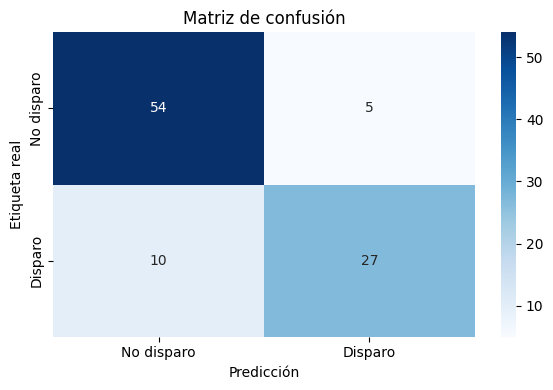

In [171]:
print("\nResultados globales:")
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(f"Matriz de confusión:")
print(cm)
for model_name, cm in results.items():
    print(f"{model_name}:\n{cm}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No disparo", "Disparo"], yticklabels=["No disparo", "Disparo"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()